# Book Database Exploration and Recommendation Mockup

## Preprocessing de los datos y exploración para Insights

In [2]:
#Primero importamos todo lo necesario
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Cargamos los datasets
books = pd.read_csv(r"Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


In [4]:
#Analizamos la bd de Books
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
#No necesitamos las columnas de imagenes
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [6]:
#Buscamos errores en el dataset de valores nulos
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [7]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [8]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [9]:
#Corregimos
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [10]:
#Corregimos los años
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [11]:
pd.set_option('display.max_colwidth', -1)

In [12]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [13]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [14]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [15]:
#Convertimos a ints
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [16]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [17]:
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [18]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [19]:
#Hacemos mayúsculas todo en ISBN para normalizar
books['ISBN'] = books['ISBN'].str.upper()

In [20]:
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [21]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [22]:
#Ya limpiamos y corregimos todo en books, ahora users
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [23]:
print(users.isna().sum())               

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [24]:
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [25]:
required = users[users['Age'] <= 90]
required = required[required['Age'] >= 10]

mean = round(required['Age'].mean())   
mean

35

In [26]:
users.loc[users['Age'] > 80, 'Age'] = mean
users.loc[users['Age'] < 10, 'Age'] = mean
users['Age'] = users['Age'].fillna(mean)
users['Age'] = users['Age'].astype(int)

In [27]:
#Para corregir la columna de ubicación, dividimos en dif columnas
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

#Quitamos entradas inválidas y las reemplazamos por Other
for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',': 
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':  
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

#Corregimos cuando lugares ya fueron especificados en otra columna
temp = []
for ent in city:
    c = ent.split('/') 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

#Ahora contamos las celdas que no tuvieron valores
print(count_no_country)
print(count_no_state)

4659
16044


In [28]:
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [30]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


In [31]:
#Ya vimos que quedó el de Users, ahora finalmente el de Rating
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [32]:
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [33]:
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [34]:
#Revisamos sintaxis de ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [35]:
#Los valores extra de ISBN los quitamos cuando ya existan en el ds de Books
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [36]:
ratings['ISBN'] = ratings['ISBN'].str.upper()

ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [37]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [38]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [39]:
#Terminamos de corregir los datasets, ahora para convertirlos en uno solo
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int64 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.4+ MB


In [40]:
#Como hay ratings en 0, hay que dividirlos para que se vea una comparación racional entre los válidos
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [41]:
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [42]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


### Exploración de Datos

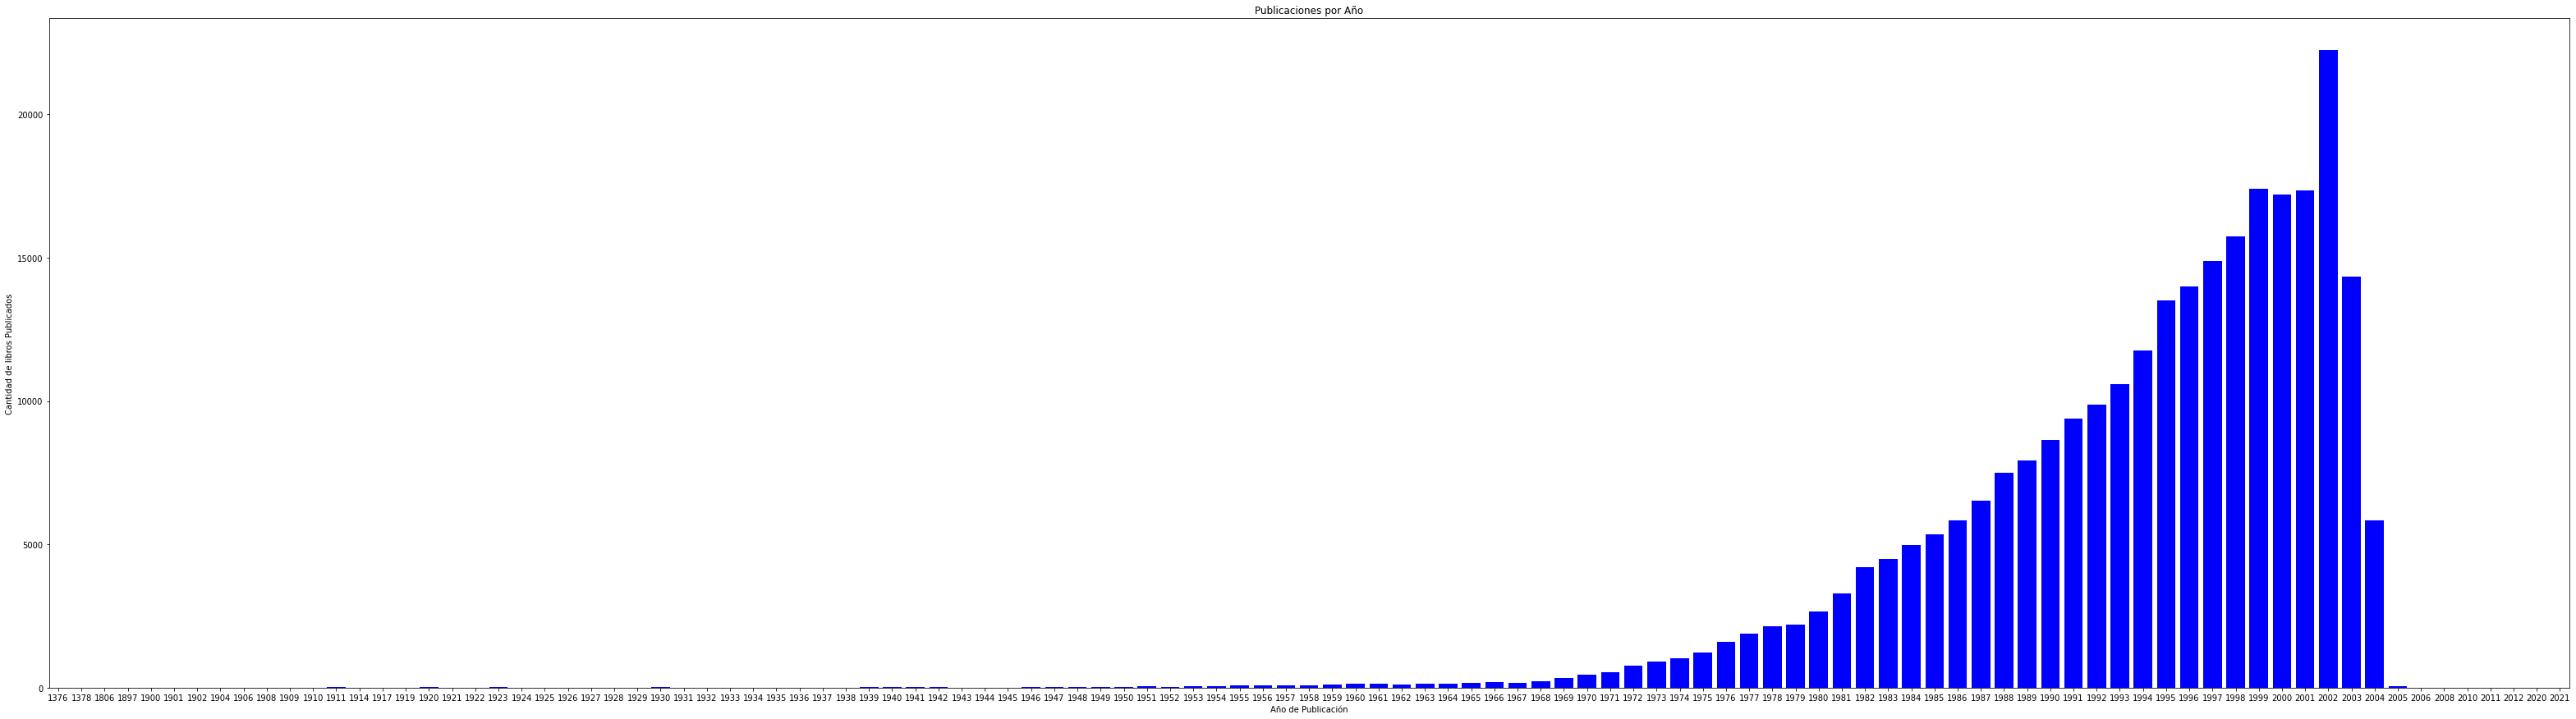

In [43]:
#Ahora vamos a explorar los datos y ver los insights que podemos sacar
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Cantidad de libros Publicados")
plt.xlabel("Año de Publicación")
plt.title("Publicaciones por Año")
plt.margins(x = 0)
plt.show()

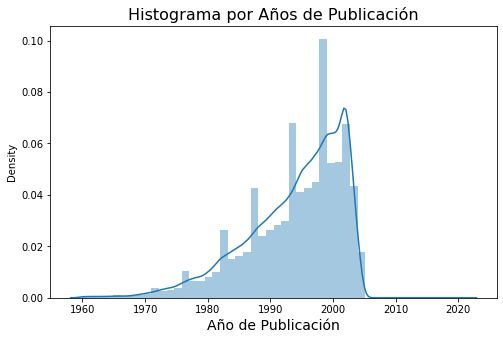

In [44]:
fig=plt.figure(figsize=(8,5))
y1 = books[books['Year-Of-Publication'] >= 1960]
y1 = y1[y1['Year-Of-Publication'] <= 2021]
sns.distplot(y1['Year-Of-Publication'])
plt.xlabel('Año de Publicación',size=14)
plt.title('Histograma por Años de Publicación',size=16)
plt.show()

Insight 1:
Podemos ver en la gráfica que desde mediados de los 1900 fue creciendo exponencialmente la publicación de libros, llegando a un tope en 2001/2002 (Se utilizó 2002 para almacenar todos los libros con año de publicación 0 o mayor a 2021), y desde el 2004 en adelante prácticamente no se ha actualizado esta base de datos con libros recientes.

Text(0.5, 1.0, 'Cantidad de Libros por Autor (Top 15)')

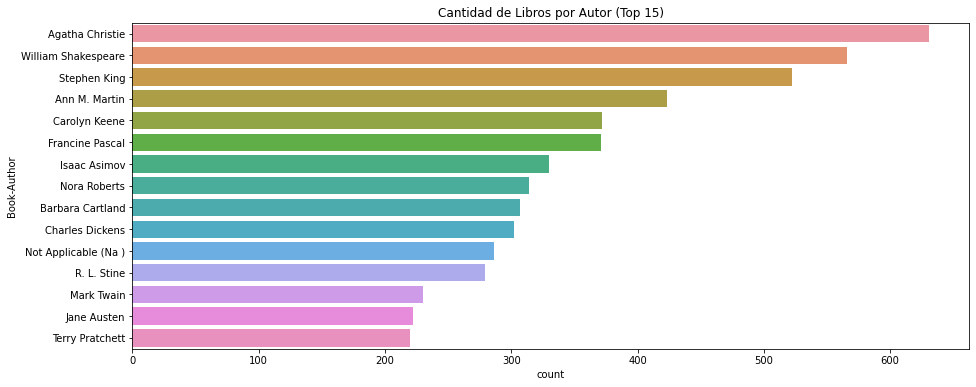

In [45]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("Cantidad de Libros por Autor (Top 15)")

Insight 2:
Se puede ver el top de autores con más publicaciones de libros, con el top 15 rebasando las 200 publicaciones

Text(0.5, 1.0, 'Cantidad de Libros por Editorial (Top 15)')

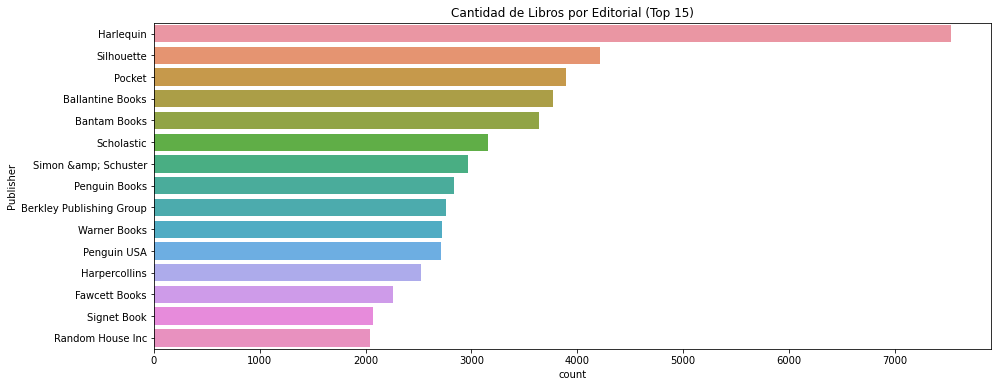

In [46]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("Cantidad de Libros por Editorial (Top 15)")

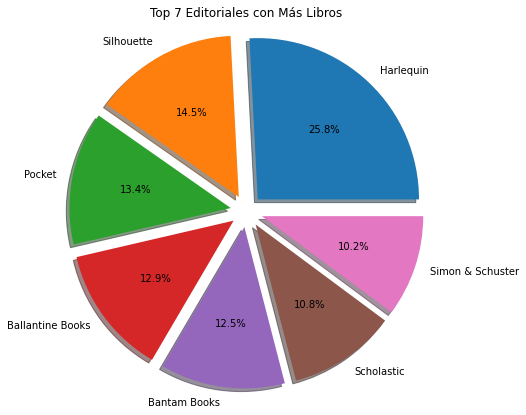

In [47]:
my_dict=(books['Publisher'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon & Schuster'
sizes = [count['count'].iloc[0],count['count'].iloc[1],count['count'].iloc[2],count['count'].iloc[3],count['count'].iloc[4],
         count['count'].iloc[5],count['count'].iloc[6]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )
fig1 , ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Top 7 Editoriales con Más Libros")
ax1.axis ('equal')
plt.show()

Insight 3:
De la misma manera, el top de editoriales con libros, con el top 15 rebasando los 2000 libros publicados a lo largo de los años

<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

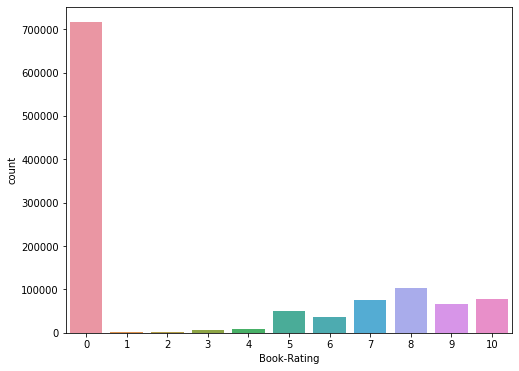

In [48]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Insight 4: 
Sin filtrar, se ve la cantidad de Ratings nulos en 0 contra el resto

Text(0.5, 1.0, 'Ratings Válidos')

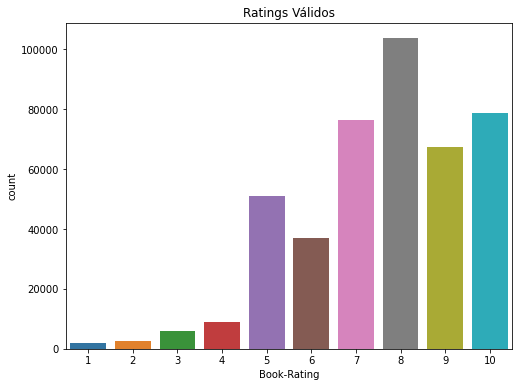

In [49]:
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Ratings Válidos")

Insight 5:
Dentro de los libros con Ratings válidos, se encuentra la mayoría con calificación de 8, seguidos por calificaciones de 10 y 7

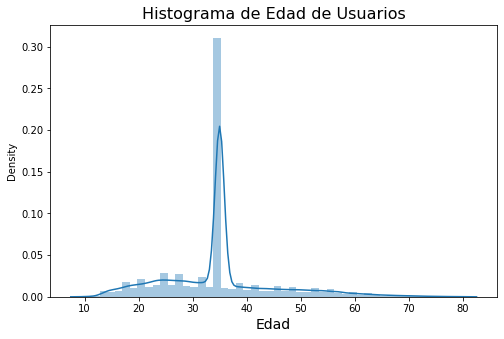

In [50]:
fig=plt.figure(figsize=(8,5))
sns.distplot(users['Age'])
plt.xlabel('Edad',size=14)
plt.title('Histograma de Edad de Usuarios',size=16)
plt.show()

Insight 6:
Viendo la distribución de edades, se puede ver que destacan por una gran cantidad usuarios a mediados de sus 30s. Las edades van creciendo desde los 16 años aproximadamente, y a partir de los 40 va decrementando.

Text(0.5, 1.0, 'Cantidad de Lectores por Ciudad (Top 15)')

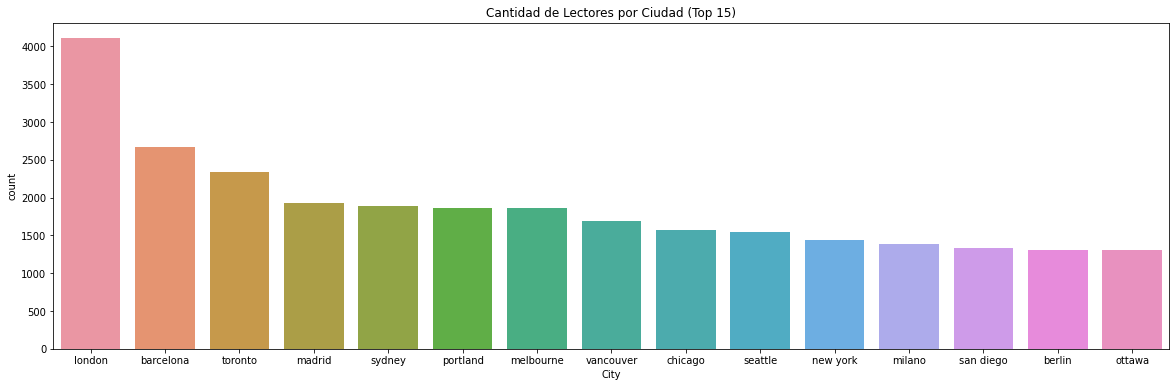

In [51]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("Cantidad de Lectores por Ciudad (Top 15)")

Insight 7:
Con esta gráfica se muestran las ciudades con mayor cantidad de usuarios, liderando con Londres, Barcelona y Toronto.

Text(0.5, 1.0, 'Cantidad de Lectores por Estado (Top 15)')

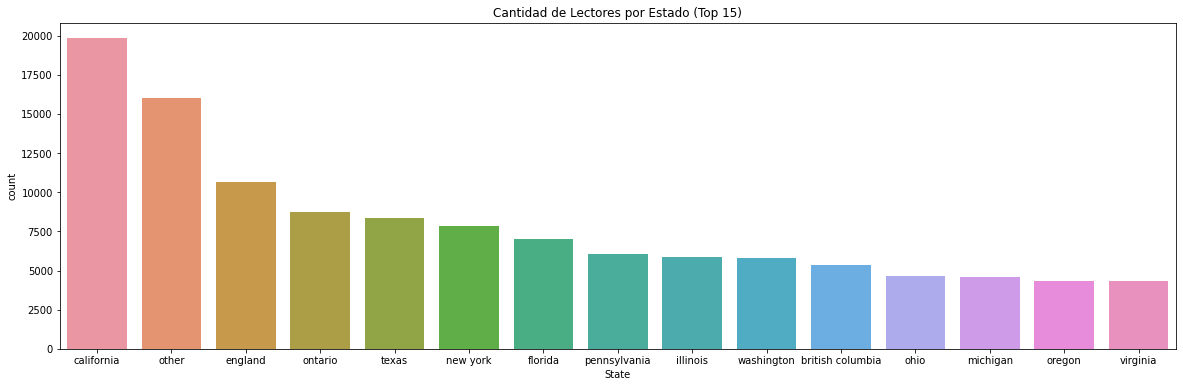

In [52]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("Cantidad de Lectores por Estado (Top 15)")

Text(0.5, 1.0, 'Cantidad de Lectores por País (Top 10)')

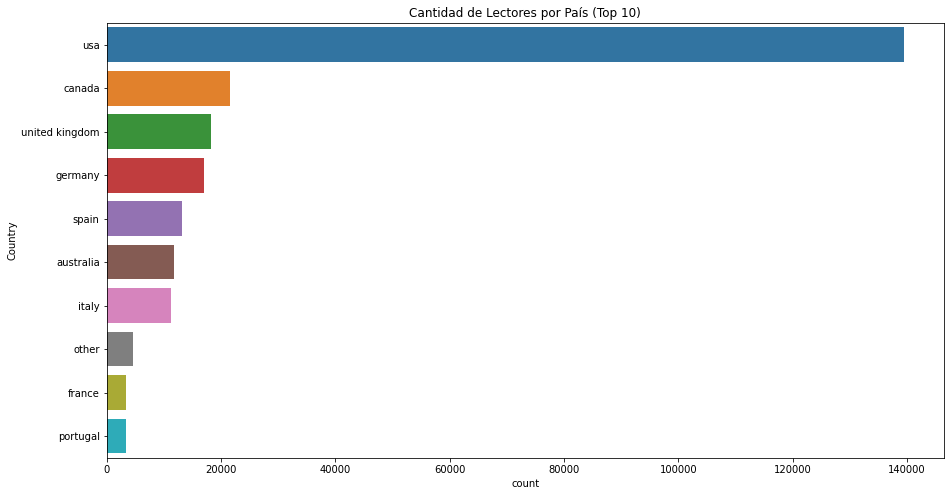

In [53]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("Cantidad de Lectores por País (Top 10)")

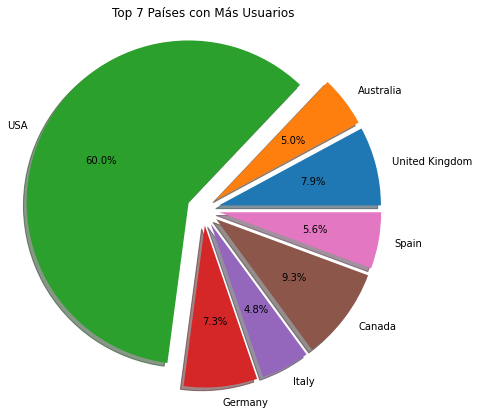

In [54]:
my_dict=(users['Country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'United Kingdom','Australia','USA','Germany','Italy','Canada','Spain'
sizes = [count['count'].iloc[2],count['count'].iloc[5],count['count'].iloc[0],count['count'].iloc[3],count['count'].iloc[6],
         count['count'].iloc[1],count['count'].iloc[4]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )

fig1 , ax1 = plt.subplots(figsize=(7,7))

ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Top 7 Países con Más Usuarios")
ax1.axis ('equal')

plt.show()

Insight 8:
Se puede ver que en USA hay la mayoría de los usuarios de los libros, por lo que nos podemos centrar ahí para ver un desglose.

Text(0.5, 1.0, 'Cantidad de Lectores por Estado (USA) (Top 15)')

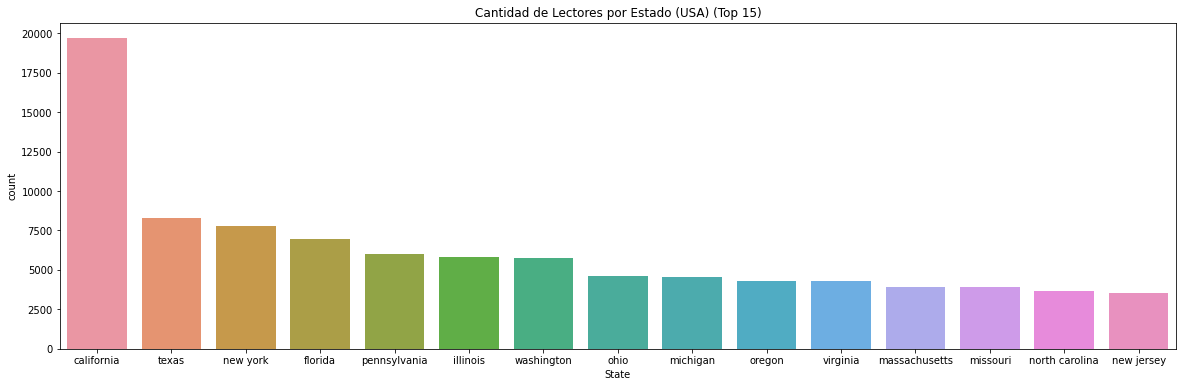

In [55]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("Cantidad de Lectores por Estado (USA) (Top 15)")

Insight 9:
Ahora sí, podemos ver los estados en USA donde se concentra la mayoría de usuarios.

Text(0.5, 1.0, 'Cantidad de Ratings por Libro (Top 15)')

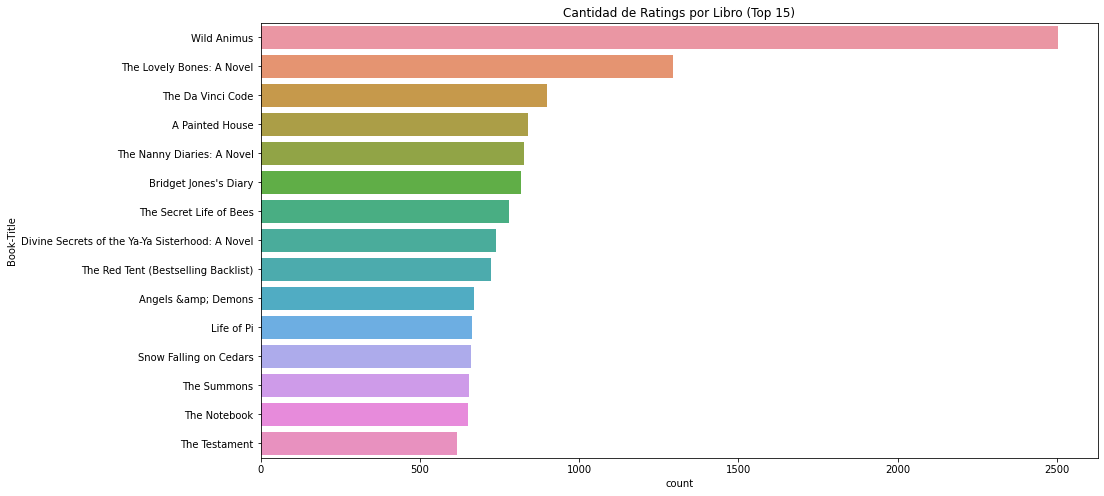

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Cantidad de Ratings por Libro (Top 15)")

Insight 10:
Con esta gráfica, podemos ver la cantidad de calificaciones que se le ha dado a los libros, sacando los libros más populares para poder recomendar en un aspecto general.

## Prueba de Sistema de Recomendaciones

#### Test para ver cómo puede funcionar el engine de recomendaciones utilizando este dataset

In [57]:
# Creamos un espacio donde el usuario ponga un libro y la cantidad de libros que quiere que se le recomiende
bookName = input("Ingresa un Libro: ")
number = int(input("Ingresa la cantidad de recomendaciones deseada: "))

Ingresa un Libro: The Notebook
Ingresa la cantidad de recomendaciones deseada: 5


In [58]:
#Creamos primero una recomendación por popularidad
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Número de recomendaciones inválido. Intenta de nuevo"

In [59]:
print("Top ", number, " Libros Más Populares: ")
popularity_based(dataset1, number)

Top  5  Libros Más Populares: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


In [60]:
#También se podría recomendar libros por el mismo autor
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [61]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [62]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Nombre de Libro Inválido. Intenta de nuevo.")


Books by same Author:

A Bend in the Road
Message in a Bottle
The Wedding
The Rescue
The Guardian


Books by same Publisher:

Sex &amp; the City
A Bend in the Road
The Sky Is Falling
Standoff
Cradle


In [64]:
#Podemos recomendar basado en usuarios que ya calificaron anteriormente
df=dataset1[dataset1['Book-Rating']>0]
counts1 = df['User-ID'].value_counts()
df= df[df['User-ID'].isin(counts1[counts1 > 200].index)]
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
25,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8,35,other,other,other
26,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,11676,9,35,other,other,other
27,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,11676,8,35,other,other,other
28,0440234743,The Testament,John Grisham,1999,Dell,11676,9,35,other,other,other
29,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,11676,8,35,other,other,other
...,...,...,...,...,...,...,...,...,...,...,...
248807,1583144803,First Touch: Serenade/Forever Yours/Beguiled (Arabesque Collector's Series),Sandra Kitt,2004,Arabesque,216012,7,34,clevelad,ohio,usa
248808,1583145486,Southern Comfort (Arabesque),Sandra Kitt,2004,Arabesque,216012,7,34,clevelad,ohio,usa
248809,1585710164,Bound by Love (Indigo: Sensuous Love Stories),Beverly Clark,2000,"Genesis Press, Ltd.",216012,7,34,clevelad,ohio,usa
248810,1585710806,Tattooed Tears (Indigo: Sensuous Love Stories),Tanya T. Henderson,2002,Genesis Press (MS),216012,7,34,clevelad,ohio,usa


In [65]:
len(df['ISBN'].unique())

44302

In [66]:
cdf1=df[['User-ID','ISBN','Book-Rating']]
cdf=pd.merge(cdf1,books,on='ISBN')
cdf

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,11676,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,11676,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
2,46398,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
3,230522,0399135782,7,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
4,11676,0671870432,8,PLEADING GUILTY,Scott Turow,1993,Audioworks
...,...,...,...,...,...,...,...
58203,216012,1583144803,7,First Touch: Serenade/Forever Yours/Beguiled (Arabesque Collector's Series),Sandra Kitt,2004,Arabesque
58204,216012,1583145486,7,Southern Comfort (Arabesque),Sandra Kitt,2004,Arabesque
58205,216012,1585710164,7,Bound by Love (Indigo: Sensuous Love Stories),Beverly Clark,2000,"Genesis Press, Ltd."
58206,216012,1585710806,7,Tattooed Tears (Indigo: Sensuous Love Stories),Tanya T. Henderson,2002,Genesis Press (MS)


In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cdf['User_ID']=le.fit_transform(cdf['User-ID'])
cdf['title_id']=le.fit_transform(cdf['Book-Title'])
cdf.drop('User-ID',axis=1,inplace=True)
cdf

,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,User_ID,title_id
0,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,4,6530
1,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,4,33116
2,0399135782,9,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,23,33116
3,0399135782,7,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,97,33116
4,0671870432,8,PLEADING GUILTY,Scott Turow,1993,Audioworks,4,22644
...,...,...,...,...,...,...,...,...
58203,1583144803,7,First Touch: Serenade/Forever Yours/Beguiled (Arabesque Collector's Series),Sandra Kitt,2004,Arabesque,92,11470
58204,1583145486,7,Southern Comfort (Arabesque),Sandra Kitt,2004,Arabesque,92,27466
58205,1585710164,7,Bound by Love (Indigo: Sensuous Love Stories),Beverly Clark,2000,"Genesis Press, Ltd.",92,4958
58206,1585710806,7,Tattooed Tears (Indigo: Sensuous Love Stories),Tanya T. Henderson,2002,Genesis Press (MS),92,28877


In [68]:
from surprise import Reader
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(cdf[['User_ID','title_id','Book-Rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4769  1.4743  1.4937  1.4813  1.4844  1.4821  0.0068  
MAE (testset)     1.0806  1.0765  1.0848  1.0834  1.0902  1.0831  0.0046  
Fit time          2.65    2.69    2.68    2.70    2.79    2.70    0.05    
Test time         0.07    0.06    0.06    0.06    0.06    0.06    0.00    


{'test_rmse': array([1.47692965, 1.47425042, 1.49370648, 1.48133273, 1.48442535]),
 'test_mae': array([1.08055447, 1.07647576, 1.08478534, 1.0834357 , 1.09020051]),
 'fit_time': (2.6466150283813477,
  2.687000036239624,
  2.6798698902130127,
  2.702054262161255,
  2.7879159450531006),
 'test_time': (0.06559991836547852,
  0.05679893493652344,
  0.05985617637634277,
  0.05872821807861328,
  0.06395292282104492)}

In [69]:
def user_rec(id):
    user= cdf[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher','title_id']].copy()
    user = user.reset_index()
# Conseguimos el dataset completo
    data = Dataset.load_from_df(cdf[['User_ID','title_id','Book-Rating']], reader)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    user['Estimate_Score'] = user['title_id'].apply(lambda x: svd.predict(id, x).est)
    user = user.drop(['index','title_id'], axis = 1)
    user= user.sort_values('Estimate_Score' , ascending = False)
    counts1 = user['Estimate_Score'].value_counts()
    user = user[user['Estimate_Score'].isin(counts1[counts1 == 1].index)]
    return user.head(10)

In [72]:
pd.set_option('display.max_rows',None) 
Uid=100
print("ID del Usuario: ",Uid)
details=cdf.loc[cdf['User_ID']==Uid]
id=details['User_ID'].iloc[0]
a=user_rec(id)
a.reset_index(inplace=True)
a.drop(['index'],axis=1,inplace=True)
details.reset_index(inplace=True)
details
details.drop(['index','User_ID','title_id','ISBN'],axis=1,inplace=True)
print("\nEste usuario ha calificado estos libros anteriormente:")
title_1=list(details['Book-Title'])
rat1=list(details['Book-Rating'])
for i,j in zip(title_1,rat1):
    print(i,'=>',j)
print("\nAquí hay algunas recomendaciones para el usuario con el mayor puntaje estimado que daría:")

display(a)

ID del Usuario:  100

Este usuario ha calificado estos libros anteriormente:
From the Corner of His Eye => 8
The Five People You Meet in Heaven => 10
Chicken Soup for the Soul (Chicken Soup for the Soul) => 10
The Rescue => 10
The Guardian => 10
Nights in Rodanthe => 10
Dreamcatcher => 10
The Diary of Ellen Rimbauer: My Life at Rose Red => 10
The Girl Who Loved Tom Gordon : A Novel => 10
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson => 10
The Notebook => 10
Pay It Forward => 10
Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series) => 8
The Stand (The Complete and Uncut Edition) => 10
Basket Case => 10
The Guardian => 10
Chicken Soup for the Cat and Dog Lover's Soul - Celebrating Pets as Family with Stories About Cats, Dogs and Other Critters => 10
The Green Mile: The Complete Serial Novel => 10
Lucky You => 10
Sick Puppy => 10
The Green Mile => 10
The Tommy

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Estimate_Score
0,0440219604,I Hadn't Meant to Tell You This,Jacqueline Woodson,1995,Laurel-Leaf Books,9.999257
1,0373484070,Sons of Texas : Callaway Country,Annette Broadrick,2000,Silhouette,9.997539
2,0671432672,TWILIGHT,Leigh Nichols,1984,Pocket,9.991610
3,0802064981,"William Marshal: Knight-Errant, Baron, and Regent of England (Medieval Academy Reprints for Teaching, 13)",Sidney Painter,1982,University of Toronto Press,9.991353
4,0452008751,Alexander's Bridge,Willa Cather,1988,Penguin USA,9.988670
5,0452265436,The Joys of Yinglish,Leo Rosten,1990,Penguin USA,9.988299
6,1850150311,Challenges: A Teenage Boy's Practical Workbook for Career and Personal Planning,Mindy Bingham,1985,Exley Publications Ltd,9.986913
7,058608293X,A dictionary of British folk customs,Christina Hole,1986,Paladin Grafton Books,9.981505
8,0312981260,Temple,Matthew Reilly,2002,St. Martin's Paperbacks,9.980474
9,0765300796,"East of the Sun, West of the Moon (Tom Doherty Associates Book)",Carole Bellacera,2001,Forge,9.977218


In [73]:
#Otra recomendación que se usa en lugares como Netflix es el más popular por año
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN')

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
73895,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz
73896,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
130309,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81469,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125519,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside
48634,0373226888,Tommy's Mom,Linda O. Johnston,1902,Harlequin
104339,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta
103193,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906,Ams Pr
24664,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908,Yoga Publication Society
53807,0892760508,New Birth,Kenneth Hagin,1911,Faith Library Publications


In [74]:
#Collaborative Filter (User-Item)
#Otra cosa que podemos hacer es recomendar libros con sus ratings mayores a 50
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [75]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [76]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [77]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])


def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Libro Seleccionado:")
    printBookDetails(bookID)
    
    print("\n\nRecomendaciones:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [78]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Libro Seleccionado:
The Notebook


Recomendaciones:

A Walk to Remember
Message in a Bottle
The Rescue
The Glass Lake
The Guardian


In [79]:
#Usando un algoritmo de kNN podemos recomendar libros parecidos
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

Message in a Bottle
A Walk to Remember
Nights in Rodanthe
The Wedding
The Rescue


In [80]:
#Este es más un stretch para probar como recomendar basado en contenido
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 6)

In [81]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [82]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [83]:
print("Libros Recomendados:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Libros Recomendados:

The Murder Book
Into Thin Air : A Personal Account of the Mt. Everest Disaster
Everything's Eventual : 14 Dark Tales
The Summons
Isle of Dogs


In [84]:
#Hybrid Approach
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Libro Seleccionado:\n")
print(bookName)
print("\nLibros Recomendados:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Libro Seleccionado:

The Notebook

Libros Recomendados:

A Walk to Remember
The Murder Book
Message in a Bottle
Into Thin Air : A Personal Account of the Mt. Everest Disaster
The Rescue
